In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import sys
import seaborn as sns
import random 
import cartopy as cp
import stormeunice as eun
import multiprocessing
import glob
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.transforms as mtransforms

sys.path.append('/home/e/ermis/moarpalettes')
from moarpalettes import get_palette

sns.set_theme(style="white")
sns.set_style("white")
%matplotlib inline

random.seed(10)

# Data import and pre-processing

In [2]:
# Import track data
P1 = multiprocessing.Pool(40)
ifs_tracks = P1.map(eun.lagrangian.Lagrange.import_medr_tracks_TE, 
                    glob.glob('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_[!2]*'))
P1.close()

ifs_tracks = pd.concat(ifs_tracks)
ifs_tracks['date'] = pd.to_datetime(ifs_tracks.loc[:,['year','month','day','hour']])

# add era track in
era_track = pd.read_csv('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_2022_0',
                        skipinitialspace=True)

era_track['expid'] = 'era5'
era_track['experiment'] = 'era5'
era_track['inidate'] = pd.to_datetime('2022-01-01')
era_track['number'] = 0
era_track['date'] = pd.to_datetime(era_track.loc[:,['year','month','day','hour']])

all_tracks = pd.concat([ifs_tracks,era_track])

eunice_track = era_track.query('track_id==5')

In [3]:
ifs_tracks_filter = ifs_tracks.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min))
eunice_filter = eunice_track.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min)).iloc[0]

# starttime criterion - must be detected within 12 hours (before or after) the ERA5 track detectino time
starttime_crit = (ifs_tracks_filter.date - eunice_filter.date).dt.total_seconds().abs()<(12*60*60)
# starting location criterion - must start within 10 degrees of the ERA5 track starting point
startloc_crit = np.sqrt((ifs_tracks_filter.lon-eunice_filter.lon)**2+(ifs_tracks_filter.lat-eunice_filter.lat)**2)<10
# depth criterion - must reach a depth of at least 980 hPa
minmsl_crit = ifs_tracks_filter.msl < 98000

ifs_tracks_filtered = ifs_tracks_filter.loc[starttime_crit&startloc_crit&minmsl_crit]
ifs_eunice_list = ifs_tracks.set_index(['track_id','inidate','experiment','number']).sort_index().loc[ifs_tracks_filtered.index].reset_index()

In [4]:
# For members with more than one Eunice-like track: keep the ones with the longest track? 
multi_track_members = ifs_eunice_list.groupby(['inidate','experiment','number','track_id']).agg(dict(year = lambda x: 1)).groupby(['inidate','experiment','number']).count().query('year > 1')

for idx in multi_track_members.index:
    track_dists = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={}'.format(*idx)).groupby('track_id').apply(lambda x: eun.lagrangian.Lagrange.eunice_dist(x,eunice_track=eunice_track))
    num_reject = track_dists.idxmax()
    ifs_eunice_list_idx = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={} & track_id=={}'.format(*idx,num_reject)).index
    ifs_eunice_list = ifs_eunice_list.drop(ifs_eunice_list_idx)

In [5]:
ERA5_tracks = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/ERA5/EU025/sfc/2022.h5')
ERA5_eunice_track = ERA5_tracks.query('uid=="202202079"')

ERA5_data = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc').sel(time=ERA5_eunice_track.date.values)
ERA5_data['centroid_lon'] = ('time',(ERA5_eunice_track.long*4).round()/4)
ERA5_data['centroid_lat'] = ('time',(ERA5_eunice_track.lat*4).round()/4)

ERA5_eunice_stormframe = ERA5_data.groupby('time').apply(eun.lagrangian.Lagrange.lagrangian_frame)

In [6]:
%%capture 
# Ignore outputs

# Import field data, Lagrangian fram
curr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')
pi_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/*.nc',
                              preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list),
                              combine='nested',
                              concat_dim=['inidate'],
                              parallel=True, 
                              engine='netcdf4')
incr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')

# Calculate statistics

In [7]:
ifs_eunice_list_stats = ifs_eunice_list.loc[ifs_eunice_list.inidate.isin(['2022-02-10','2022-02-14','2022-02-16'])].groupby(['experiment','inidate','number','track_id']).agg(dict(msl=min,date=min,vo=max)).reset_index()
ifs_eunice_list_stats['date'] = (ifs_eunice_list_stats.date - eunice_filter.date).dt.total_seconds()/(3600*24)

In [8]:
ifs_eunice_list_stats = ifs_eunice_list.loc[ifs_eunice_list.inidate.isin(['2022-02-10','2022-02-14','2022-02-16'])].groupby(['experiment','inidate','number','track_id']).agg(dict(msl=min,date=min,vo=max)).reset_index()
ifs_eunice_list_stats['date'] = (ifs_eunice_list_stats.date - eunice_filter.date).dt.total_seconds()/(3600*24)

In [9]:
# Add wind speed maxima
curr_max_winds = curr_storms.ws100.max(dim=['storm_lat','storm_lon', 'timestep'], skipna=True).squeeze().to_dataframe().reset_index()
incr_max_winds = incr_storms.ws100.max(dim=['storm_lat','storm_lon', 'timestep'], skipna=True).squeeze().to_dataframe().reset_index()
pi_max_winds = pi_storms.ws100.max(dim=['storm_lat','storm_lon', 'timestep'], skipna=True).squeeze().to_dataframe().reset_index()

ifs_eunice_list_stats2 = ifs_eunice_list_stats.merge(curr_max_winds, how='outer', on=['inidate', 'experiment', 'number'])

In [10]:
ifs_eunice_list_stats2 = ifs_eunice_list_stats2.merge(incr_max_winds, how='outer')
ifs_eunice_list_stats2 = ifs_eunice_list_stats2.merge(pi_max_winds, how='outer')
ifs_eunice_list_stats2['vo'] = ifs_eunice_list_stats2['vo']*10**6
ifs_eunice_list_stats2['msl'] = ifs_eunice_list_stats2['msl']/100

In [11]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    https://stackoverflow.com/questions/40452759/pandas-latitude-longitude-to-distance-between-successive-rows
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1 = np.radians(lat1)
        lat2 = np.radians(lat2)
        lon1 = np.radians(lon1)
        lon2 = np.radians(lon2)

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [12]:
def calculate_track_speed(input):  # new version
    smoothed_vo = input.groupby(['experiment','inidate','number','track_id']).rolling(3, center=True, min_periods=1).vo.mean()
    grouped = input.groupby(['experiment','inidate','number','track_id'])

    # go through all storms to calculate mean track speed around peak vo
    track_speed = []
    for name, group in grouped: 
        peak_vo = group.rolling(3, center=True).mean().vo.idxmax()
        peak_vo_datetime = group.date.loc[peak_vo] 
        tmp = group.where((group.date < (peak_vo_datetime-pd.Timedelta(12, unit='h'))) & (group.date >= (peak_vo_datetime+pd.Timedelta(12, unit='h'))))
        tmp = haversine(group.lat.shift(), group.lon.shift(), group.loc[1:, 'lat'], group.loc[1:, 'lon']).cumsum()
        track_speed.append(tmp.iloc[-1]/24)

    output = grouped.date.min().reset_index()
    output['track_speed'] = track_speed

    # calculatee full track time
    start_time = grouped.date.min().reset_index()
    end_time = grouped.date.max().reset_index()
    track_time = (end_time.date - start_time.date).astype('timedelta64[h]')
    output['track_time'] = track_time

    # calculate full track length
    track_dist = []
    for name, group in grouped:
        tmp = haversine(group.lat.shift(), group.lon.shift(),
                        group.loc[1:, 'lat'], group.loc[1:, 'lon']).cumsum()
        track_dist.append(tmp.iloc[-1])
    output['track_dist'] = track_dist
    return output

In [13]:
def calculate_deepenening_time(input):

    smoothed_vo = input.groupby(['experiment','inidate','number','track_id']).rolling(3, center=True, min_periods=1).vo.mean()
    max_vo = smoothed_vo.groupby(['experiment','inidate','number','track_id']).idxmax().reset_index()
    max_idx = []
    for i in range(len(max_vo)):
        max_idx.append(max_vo.vo[i][-1])  # TODO: WHy at vo maximum
    start_time = input.groupby(['experiment','inidate','number','track_id']).date.min().reset_index()
    max_time = input.loc[max_idx].reset_index()
    dt = (max_time.date - start_time.date).astype('timedelta64[h]')
    output = start_time.copy(deep = True)
    output['deepening_time'] = dt
    return output

In [14]:
ifs_eunice_list_stats3 = pd.merge(ifs_eunice_list_stats2, calculate_deepenening_time(ifs_eunice_list)
                                  .drop(columns = 'date'), how = 'outer', on = ['experiment','inidate','number','track_id'])
ifs_eunice_list_stats3 = pd.merge(ifs_eunice_list_stats3, calculate_track_speed(ifs_eunice_list)
                                  .drop(columns = 'date'),
                                  how='outer', on = ['experiment','inidate','number','track_id'])

/tmp/user/27529/ipykernel_2397456/1334334795.py:8: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date', 'experiment', 'inidate'], dtype='object')
  peak_vo = group.rolling(3, center=True).mean().vo.idxmax()
/tmp/user/27529/ipykernel_2397456/1334334795.py:8: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date', 'experiment', 'inidate'], dtype='object')
  peak_vo = group.rolling(3, center=True).mean().vo.idxmax()
/tmp/user/27529/ipykernel_2397456/1334334795.py:8: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns w

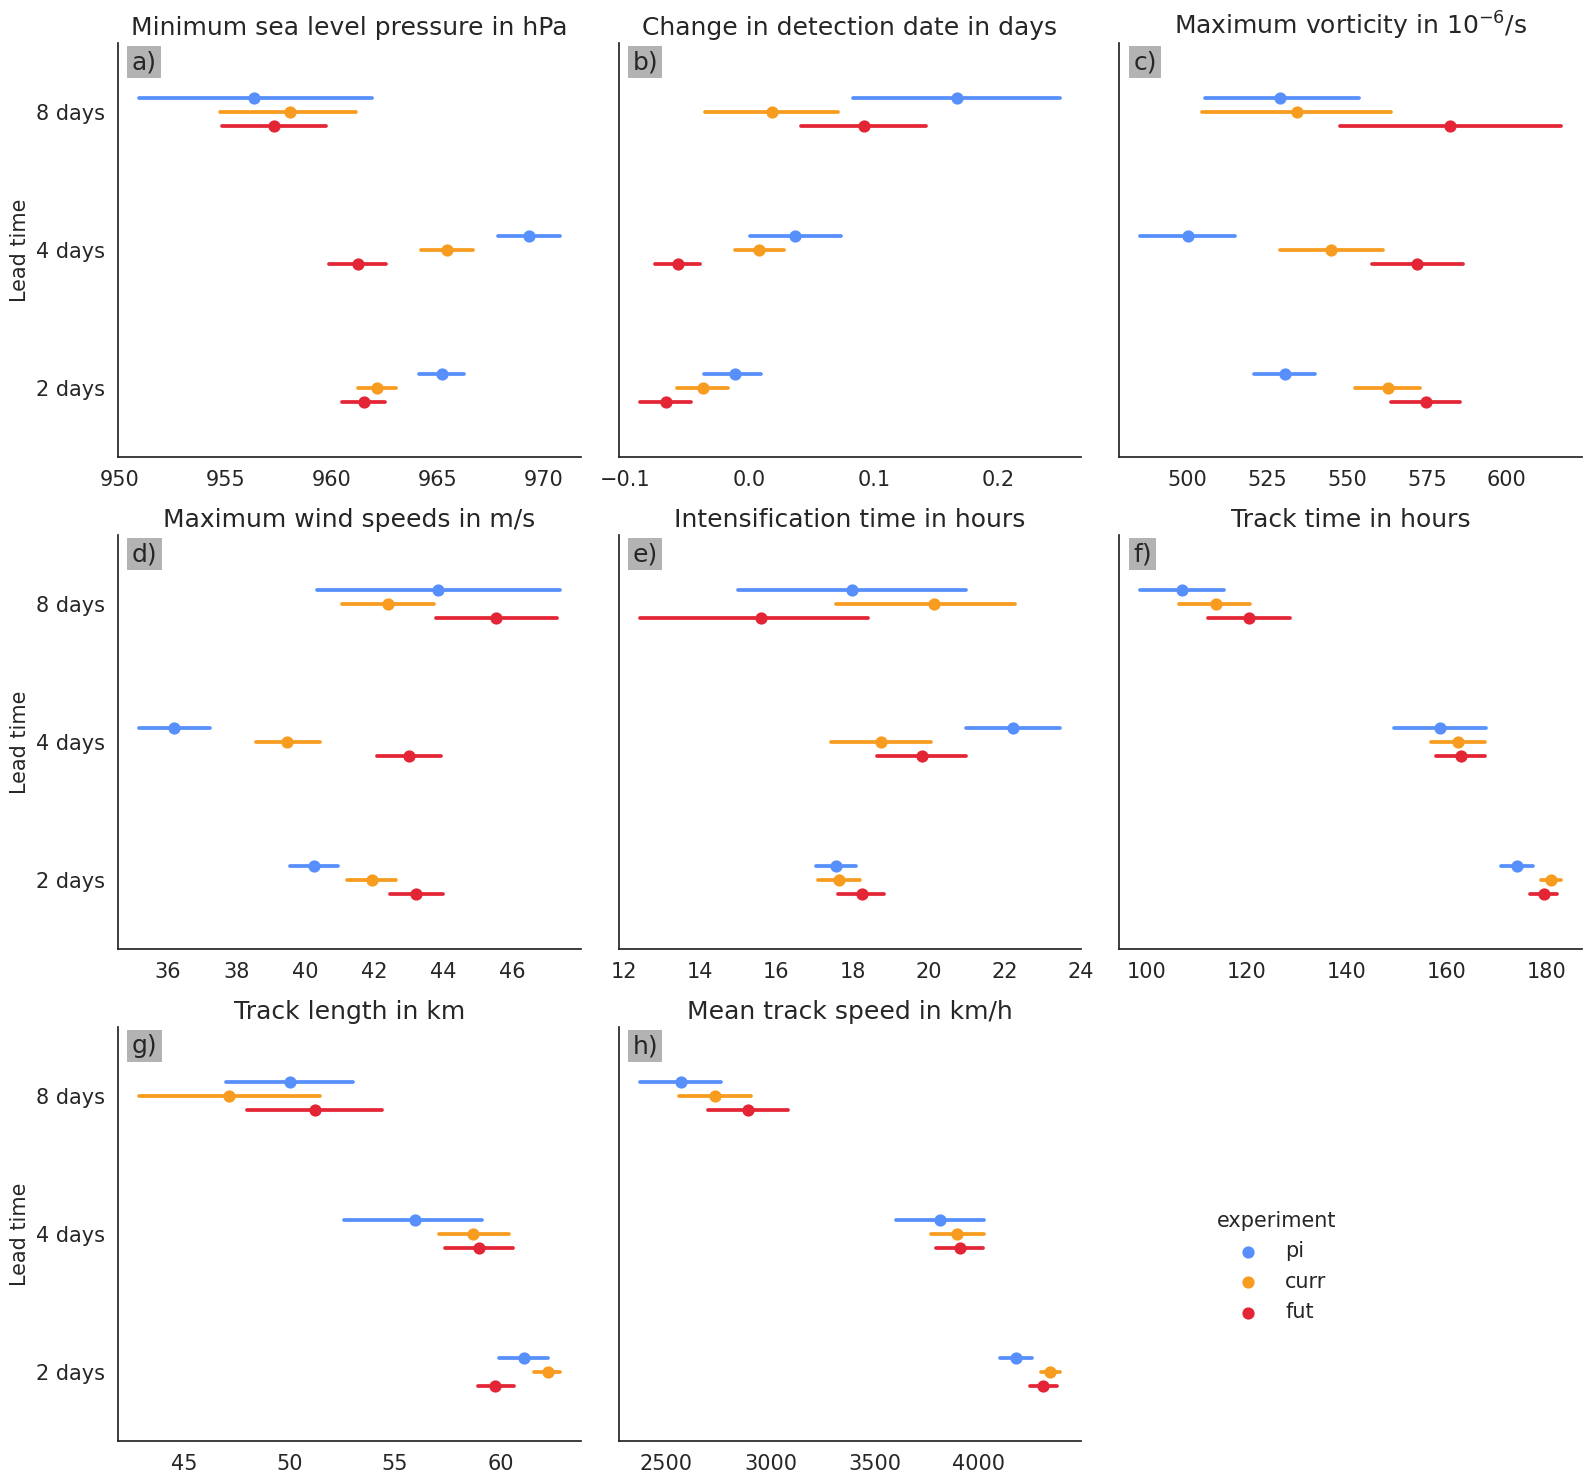

In [26]:
fs = 18
g = sns.catplot(data=ifs_eunice_list_stats3.set_index(['experiment','inidate'])
                .drop(['track_id', 'number'], axis=1).stack().astype(float)
                .reset_index()
                .rename({'level_2':'variable',0:'value'}, axis=1),
                        x='value',
                        col='variable',
                        y='inidate',
                        hue='experiment',
                        hue_order=['pi','ENS','incr'],
                        palette=get_palette.Petroff6().to_sn_palette(),
                        kind='point',
                        join=False,
                        dodge=0.2,
                        errorbar=('ci',66),
                        n_boot=10000,
                        sharex=False,
                        legend = True,
                        col_wrap=3)

g.axes[0].set_ylabel('Lead time', fontsize=fs-3)
g.axes[3].set_ylabel('Lead time', fontsize=fs-3)
g.axes[6].set_ylabel('Lead time', fontsize=fs-3)

inidates = ['8 days', '4 days', '2 days']
g.axes[0].set_yticklabels(inidates, fontsize=fs-3)
g.axes[3].set_yticklabels(inidates, fontsize=fs-3)

# g.axes[0].set_xticks([950, 955, 960, 965, 970, 975, 980])
# g.axes[0].set_xticklabels(['950','955', '960', '965', '970', '975', '980'])
g.axes[0].xaxis.set_major_formatter(FormatStrFormatter('%d'))

g.axes[0].set_title('Minimum sea level pressure in hPa', fontsize=fs)
g.axes[1].set_title('Change in detection date in days', fontsize=fs)
g.axes[2].set_title(r'Maximum vorticity in 10$^{-6}$/s', fontsize=fs)
g.axes[3].set_title('Maximum wind speeds in m/s', fontsize=fs)
g.axes[4].set_title('Intensification time in hours', fontsize=fs)
g.axes[5].set_title('Track time in hours', fontsize=fs)
g.axes[6].set_title('Track length in km', fontsize=fs)
g.axes[7].set_title('Mean track speed in km/h', fontsize=fs)

g.axes[0].tick_params(axis='both', which='major', labelsize=fs-3)
g.axes[1].tick_params(axis='both', which='major', labelsize=fs-3)
g.axes[2].tick_params(axis='both', which='major', labelsize=fs-3)
g.axes[3].tick_params(axis='both', which='major', labelsize=fs-3)
g.axes[4].tick_params(axis='both', which='major', labelsize=fs-3)
g.axes[5].tick_params(axis='both', which='major', labelsize=fs-3)
g.axes[6].tick_params(axis='both', which='major', labelsize=fs-3)
g.axes[7].tick_params(axis='both', which='major', labelsize=fs-3)

trans = mtransforms.ScaledTranslation(10/72, -5/72, g.figure.dpi_scale_trans)
labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)']
g.axes[0].text(0.0, 1.0, labels[0], transform=g.axes[0].transAxes + trans, fontsize=fs, verticalalignment='top', bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
g.axes[1].text(0.0, 1.0, labels[1], transform=g.axes[1].transAxes + trans, fontsize=fs, verticalalignment='top', bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
g.axes[2].text(0.0, 1.0, labels[2], transform=g.axes[2].transAxes + trans, fontsize=fs, verticalalignment='top', bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
g.axes[3].text(0.0, 1.0, labels[3], transform=g.axes[3].transAxes + trans, fontsize=fs, verticalalignment='top', bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
g.axes[4].text(0.0, 1.0, labels[4], transform=g.axes[4].transAxes + trans, fontsize=fs, verticalalignment='top', bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
g.axes[5].text(0.0, 1.0, labels[5], transform=g.axes[5].transAxes + trans, fontsize=fs, verticalalignment='top', bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
g.axes[6].text(0.0, 1.0, labels[6], transform=g.axes[6].transAxes + trans, fontsize=fs, verticalalignment='top', bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
g.axes[7].text(0.0, 1.0, labels[7], transform=g.axes[7].transAxes + trans, fontsize=fs, verticalalignment='top', bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

g.set_axis_labels("")
sns.move_legend(g, "upper left", bbox_to_anchor=(.75, .2), title='experiment', fontsize=fs-3, frameon=False, title_fontsize=fs-3,)
# g.axes[7].legend(['pi', 'curr', 'fut'], title = "experiment", fontsize=fs-3, frameon=False, title_fontsize=fs-3, loc='best')
new_labels = ['pi', 'curr', 'fut']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
plt.tight_layout()


plt.savefig('figures/PAPER3_surface_langrangians_stats.png')
plt.savefig('figures/PAPER3_surface_langrangians_stats.pdf')